In [42]:
import psycopg2
from psycopg2 import OperationalError

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from IPython.display import HTML
import webbrowser

import os
os.chdir('/home/francisco/MECAD/2º Ano/Estágio/forcera/scripts/scripts_py')

# Importar funções e flags definidas em flags.py e functions.py
from functions import *
from flags import * 

***
    
    Ligação à base de dados

***

In [2]:
conn = psycopg2.connect(
    host = "contratos-base-gov1.cf87yxnqgph8.eu-central-1.rds.amazonaws.com",
    port = 5432,
    #database = "contratosbasegov",
    user = "contratosbasegov",
    password = "8n9nyeTBFUyCcLJShNrZdPUai2KQkue4")

cur = conn.cursor()

***

    Executar este comando quando ocorrer um erro ao tentar realizar uma query

***

In [64]:
cur.execute('''ROLLBACK;''')

***

# Exploração do Data Set

***

    Nome das colunas

In [4]:
def col_names(table):
    '''
    Função que retorna os nomes das colunas de uma tabela
    
    Parâmetros : 
        - table : tabela de interesse

    return : 
        - pandas DataFrame : nomes das colunas
    '''

    cur = conn.cursor()
    cur.execute('''
                SELECT column_name
                FROM information_schema.columns
                WHERE table_name = %s;''', (table,))

    cnames = pd.DataFrame(cur.fetchall())
    #cnames = [row[0] for row in cur.fetchall()]
    return cnames

HTML(pd.DataFrame(col_names('contratos')).to_html(index=True))

,0
0,id
1,n_anuncio
2,anuncio_preco_base
3,anuncio_proposalDeadline
4,anuncio_cnccs
5,anuncio_contractingProcedureAliasID
6,anuncio_contractingProcedureId
7,anuncio_drPublicationDate
8,anuncio_dreNumber
9,anuncio_dreSeries


    Número de Contratos


In [5]:
def n_contracts(table):
    '''
    Retorna o número de contratos de uma tabela pertencente à base de dados

    Parâmetros : 
        - table : tabela de interesse

    return : 
        - int : número de contrato
    '''
    
    cur = conn.cursor()
    cur.execute('''
                SELECT COUNT(*) 
                FROM "{}"; '''.format(table))
    ncontract = cur.fetchone()[0]
    return ncontract

n_contracts("contratos")

201481

    Organizar Contratos por Tipo de Procedimento

In [6]:
cur = conn.cursor()
cur.execute('''
        SELECT tipo_procedimento, COUNT (tipo_procedimento)
        FROM "contratos"
        GROUP BY "tipo_procedimento"
        ORDER BY COUNT(tipo_procedimento) DESC;;''')

df = (pd.DataFrame(cur.fetchall()))
HTML(df.to_html(index=False))

0,1
Ajuste Direto Regime Geral,97169
Consulta Prévia,43382
Concurso público,30457
Ao abrigo de acordo-quadro (art.º 259.º),21874
Ao abrigo de acordo-quadro (art.º 258.º),5628
Ajuste direto simplificado,1164
"Ajuste direto simplificado ao abrigo da Lei n.º 30/2021, de 21.05",922
Consulta Prévia Simplificada,462
Concurso limitado por prévia qualificação,327
Procedimento de negociação,28


In [7]:
cur = conn.cursor()

cur.execute('''
        SELECT "contractTypes", COUNT ("contractTypes")
        FROM "contratos"
        WHERE tipo_procedimento = 'Ajuste Direto Regime Geral'
        GROUP BY "contractTypes"
        ORDER BY  COUNT("contractTypes") DESC;;''')

df = (pd.DataFrame(cur.fetchall()))
HTML(df.to_html(index=False))

0,1
Aquisição de serviços,47866
Aquisição de bens móveis,44088
Empreitadas de obras públicas,3358
Locação de bens móveis,920
Aquisição de serviços<br/>Aquisição de bens móveis,323
Aquisição de bens móveis<br/>Aquisição de serviços,319
Concessão de obras públicas,61
Concessão de serviços públicos,44
Locação de bens móveis<br/>Aquisição de serviços,37
Aquisição de serviços<br/>Locação de bens móveis,35


In [8]:
def h(df):
    """
    Função que permite ver dataframe completa e de forma mais organizada
    """
    return HTML(df.to_html(index=False))

***

# Funções


***

    ID's dos contratos

In [9]:
def all_ids(table):
    '''
    Função que retorna todos os ids dos contratos de uma tabela

    Parâmetros :    
        - table : tabela de interesse

    Return : 
        - list : ids de todos os contratos de uma tabela 
    '''

    cur = conn.cursor()
    cur.execute(''' 
                SELECT id
                FROM "{}"; '''.format(table)) 
    return list(cur.fetchall())


ids = all_ids("contratos")

    ID's dos diferentes tipos de procedimentos

    1. Ajuste Direto Regime Geral

In [10]:
def ajuste_dir():
    """
    """
    
    cur = conn.cursor()
    
    cur.execute('''
            SELECT "id"
            FROM "contratos"
            WHERE tipo_procedimento = 'Ajuste Direto Regime Geral';''')
    
    return list(cur.fetchall())

    2. Consulta Prévia

In [11]:
def consulta_prev():
    """
    """
    
    cur = conn.cursor()
    
    cur.execute('''
            SELECT "id"
            FROM "contratos"
            WHERE tipo_procedimento = 'Consulta Prévia';''')
    
    return list(cur.fetchall())

    3. Concurso Público

In [12]:
def concurso_pub():
    """
    """
    
    cur = conn.cursor()
    
    cur.execute('''
            SELECT "id"
            FROM "contratos"
            WHERE tipo_procedimento = 'Concurso público';''')
    
    return list(cur.fetchall())

    Restringir por CPV - 72 IT services: consulting, software development, Internet and support

In [13]:
cur = conn.cursor()
cur.execute('''
            SELECT "id"
            FROM "contratos"
            WHERE cpv LIKE '72%';''')

len(cur.fetchall())

7744

In [14]:
def cpv_direto(cpv):
    
    """
    Função que retorna os id's de todos os contratos para um determinado CPV para todos os Ajustes Diretos em Regime Geral

    Parâmetros :
        cpv : inserir os dois algarismos iniciais do CPV entre '' ( https://www.publictendering.com/cpv-codes/list-of-the-cpv-codes/ )
    
    Return :
        tuple : id's dos contratos
    """
    
    cur = conn.cursor()
    cur.execute('''
                SELECT "id"
                FROM "contratos"
                WHERE cpv LIKE %s AND tipo_procedimento = 'Ajuste Direto Regime Geral';''', (cpv + '%',))
    
    return cur.fetchall()

In [15]:
def cpv_cpub(cpv):

    """
    Função que retorna os id's de todos os contratos para um determinado CPV para todos os Concursos Públicos

    Parâmetros :
        cpv : inserir os dois algarismos iniciais do CPV entre '' ( https://www.publictendering.com/cpv-codes/list-of-the-cpv-codes/ )
    
    Return :
        tuple : id's dos contratos
    """
    
    cur = conn.cursor()
    cur.execute('''
                SELECT "id"
                FROM "contratos"
                WHERE cpv LIKE %s AND tipo_procedimento = 'Concurso público';''', (cpv + '%',))

    
    return cur.fetchall()

In [16]:
def cpv(cpv, proc):

    """
    Função que retorna os id's de todos os contratos para um determinado CPV para todos os Concursos Públicos

    Parâmetros :
        cpv : inserir os dois algarismos iniciais do CPV entre '' ( https://www.publictendering.com/cpv-codes/list-of-the-cpv-codes/ )
    
    Return :
        tuple : id's dos contratos
    """
    
    cur = conn.cursor()
    cur.execute('''
                SELECT "id"
                FROM "contratos"
                WHERE cpv LIKE %s AND tipo_procedimento = %s;''', (cpv + '%', proc))

    
    return cur.fetchall()

In [17]:
ajdir = cpv('72','Ajuste Direto Regime Geral')
cpub = cpv('72', 'Concurso público')

    Função que retorna contrato para número de id

In [18]:
def contrato(ide):
    '''
    Função que retorna linha da database referente ao contrato com id = ide
    '''
        
    cur = conn.cursor()
    cur.execute('''
        SELECT *
        FROM "contratos"
        WHERE id = %s; ''', (ide,))
    return pd.DataFrame(cur.fetchall())


def contratos(ide):
    '''
    Função que retorna contratos referentes a um conjunto de ids

    Parâmetros :
        ide : tuplo de id's de anúncios

    return:
        dataframe com contratos
    '''
        
    cur = conn.cursor()
    cur.execute('''
        SELECT *
        FROM "contratos"
        WHERE id IN %s; ''', (tuple(ide),))
    return pd.DataFrame(cur.fetchall())

    Função que retorna contratos a partir do número do anúncio

In [19]:
cur = conn.cursor()
cur.execute('''
            SELECT * 
            FROM "contratos"
            WHERE "n_anuncio" = '8223/2023';''')

(cur.fetchall())

[('10261946',
  '8223/2023',
  '3139486.56',
  '30',
  'False',
  '6506218',
  '13041258',
  '2023-05-22',
  '98',
  '2',
  'False',
  'False',
  'https://dre.pt/application/file/213330772',
  'Anúncio de procedimento',
  'Concurso público',
  'Serviços de consultoria para serviços de integração (PRR) - Lote 1 - Serviços de atividades de Gestão de Projetos',
  '2023-09-26',
  '2023-09-11',
  '184701.60',
  '470',
  'SPMS - Serviços Partilhados do Ministério da Saúde, E. P. E. (509540716)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=190896)',
  'Artigo 20.º, n.º 1, alínea a) do Código dos Contratos Públicos',
  'IGNÍT PEOPLE, S.A. (515777048)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=3696569)',
  'Accenture - Consultores de Gestão, S.A. (502309440)|||MARCOS BARROSA, UNIPESSOAL LDA (515371378)|||Capgemini Portugal, S.A. (504272179)|||NOS - Comunicações S.A. (502604751)|||INDRA III  SOLUÇÕES  TECNOLOGIA (TECNOCOMPORT) (503222364)|||IDW - Consultoria em Ser

In [20]:
contrato('10230172')

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,10230172,8223/2023,3139486.56,30,False,6506218,13041258,2023-05-22,98,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,Plano de Recuperação e Resiliência (PRR) – art...,None,1701117163


In [21]:
def url(id):
    """
    Função que abre página web do anúncio a partir do id do contrato. Só funciona para um contrato de cada vez
    """
    
    cur = conn.cursor()

    cur.execute('''
        SELECT "url_anuncio"
        FROM "contratos"
        WHERE "id" = %s;''',(id, ))

    return webbrowser.open(cur.fetchall()[0][0])    

    Preço contratual

In [22]:
def preco_contrato1(ide):
    '''
    Função que retorna preço contratual a partir do id do anúncio para a tabela "contratos"

    Parâmetros :
        - ide : id do anúncio

    Return : 
        - int : preço contratual
    '''
        
    cur = conn.cursor()
    cur.execute('''
        SELECT preco_contratual
        FROM "contratos"
        WHERE id = %s; ''', (ide,))
    return float(cur.fetchone()[0])



# ---------------------------------------------------------------------------------------------------------------------------------------------------------



def preco_contrato2(ide, table = ""):
    '''
    Função que retorna preço contratual a partir do id do anúncio para um dada tabela

    Parâmetros :
        - ide : id do anúncio
        - table : tabela de interesse. Caso input esteja vazio, usar tabela 'contratos'

    Return : 
        - int : preço contratual
    '''

    if table == "": 
        table = "contratos"
        
    cur = conn.cursor()
    cur.execute('''
        SELECT preco_contratual
        FROM "{}"
        WHERE id = %s; '''.format(table), (ide,))
    return float((cur.fetchone())[0])


    
# ---------------------------------------------------------------------------------------------------------------------------------------------------------
    


#def preco_contrato3(id_anuncio):
#    
#    '''
#    Função que retorna preço contratual a partir de uma lista de ids de anúncios
#    '''
#    
#    cur.execute('''
#        SELECT preco_contratual
#        FROM "contratos"
#        WHERE id IN %s; ''', (tuple(id_anuncio),))
#    
#    return np.array(cur.fetchall()[0])

def preco_contrato3(id_anuncio):
    
    '''
    Função que retorna preço contratual a partir de uma lista de ids de anúncios
    '''
    
    cur.execute('''
        SELECT preco_contratual
        FROM "contratos"
        WHERE id IN %s; ''', (tuple(id_anuncio),))

   #preco = list(cur.fetchall())
   #
   #n = len(preco)
   #p = np.zeros(n)

   #for i in range(n):
   #    p[i] = (preco[i][0]).replace(".", "").replace(",",".").replace("€","")

    p = np.array(cur.fetchall(), dtype = float).reshape(len(id_anuncio),)
    return p


    
# ---------------------------------------------------------------------------------------------------------------------------------------------------------
    



def preco_contrato4(ide, table = ""):
    '''
    Função que retorna preço contratual a partir de uma lista de ids de anúncios para uma determinada tabela

    Parâmetros :
        - ide : id do anúncio
        - table : tabela de interesse. Caso input esteja vazio, usar tabela 'contratos'

    Return : 
        - int : preço contratual
    '''

    
    if table == "": 
        table = "contratos"

    
    cur.execute('''
        SELECT preco_contratual
        FROM "{}"
        WHERE id IN %s; '''.format(table), (tuple(ide),))
    
    return np.asarray(cur.fetchall())
    

    
# ---------------------------------------------------------------------------------------------------------------------------------------------------------

In [23]:
# sum(contratos(cpub).iloc[:,18].astype(float) - preco_contrato3(cpub))

    Preço Base

In [24]:
def preco_base(ide):
    '''
    Função que retorna preço base a partir do id do anúncio para a tabela "contratos"

    Parâmetros :
        - ide : id do anúncio

    Return : 
        - tuplo : preço contratual
    '''
        
    cur = conn.cursor()
    cur.execute('''
        SELECT anuncio_preco_base
        FROM "contratos"
        WHERE id = %s; ''', (ide,))
    
    return cur.fetchone()



def preco_base1(ide):
    '''
    Função que retorna preço base a partir do id do anúncio para a tabela "contratos"

    Parâmetros :
        - ide : id do anúncio

    Return : 
        - int : preço contratual
    '''
        
    cur = conn.cursor()
    cur.execute('''
        SELECT anuncio_preco_base
        FROM "contratos"
        WHERE id = %s; ''', (ide,))


    preco = cur.fetchone()[0]
    p1 = float(preco[:-2].replace(".", "").replace(",","."))
    
    return p1



# ---------------------------------------------------------------------------------------------------------------------------------------------------------



def preco_base2(ide, table = ""):
    '''
    Função que retorna preço base a partir do id do anúncio para um dada tabela

    Parâmetros :
        - ide : id do anúncio
        - table : tabela de interesse. Caso input esteja vazio, usar tabela 'contratos'

    Return : 
        - int : preço contratual
    '''

    if table == "": 
        table = "contratos"


    cur = conn.cursor()
    cur.execute('''
        SELECT anuncio_preco_base
        FROM "{}"
        WHERE id = %s; '''.format(table), (ide,))


    preco = cur.fetchone()[0]

    if preco != 0:
        p1 = float(preco[:-2].replace(".", "").replace(",","."))
    else:
        p1 = 0
    
    return p1
    


# ---------------------------------------------------------------------------------------------------------------------------------------------------------
    


def preco_base3(id_anuncio):
    
    '''
    Função que retorna preço base a partir de uma lista de ids de anúncios
    '''
    
    cur.execute('''
        SELECT anuncio_preco_base
        FROM "contratos"
        WHERE id IN %s; ''', (tuple(id_anuncio),))
    
    preco = list(cur.fetchall())
    #return preco    
    
    # Como os valores do preco base estão no formato ---.---,--€ é precio converter em -------.-- para comparar posteriormente
    n = len(preco)
    p = np.zeros(n)
    
    for i in range(n):
    
       if preco[i][0] != 'None':
           #p[i] = (preco[i][0]).replace(".00", "").replace(".", "").replace(",",".").replace("€","")
           p[i] = (preco[i][0])
    
       else:
           pass
           
    return p


In [25]:
#np.sum(contratos(cpub).iloc[:,2].astype(float) - preco_base3(cpub))

In [26]:
## Conjunto de todos os preços base
#a = preco_base3(ids)
#
##pd.DataFrame(a).describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))
#print("Nr de Zero Values :", len(a) - (np.count_nonzero(a)))
#print("Nr de Non Zero Values :", (np.count_nonzero(a)))
#print("% non zero values : ",round(np.count_nonzero(a)/len(a) * 100,1))

#nn_index = np.where(a != 0)[0]                 # índices dos ids dos contratos com preço base não nulo
#
#id1 = np.array(ids)                            # Transformação da lista de ids em array. Assim podemos extrair os ids não nulos usando os índices acima
#
#id2 = id1[nn_index]
#id2 = id2.reshape(len(id2),1)
#
#ids_nn = tuple(map(tuple, id2))                # ids não nulos. É preciso converter em tuplo para usar como input na função de preço base
#
#pb = preco_base3(ids_nn)
#pc = preco_contrato3(ids_nn)

***

    Lista de de Contratos Públicos
    
***

In [27]:
contratos(cpub)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,10001448,4840/2023,20000.00,6,False,6417636,12848310,2023-03-27,61,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,17999.09,1700348541
1,10004158,4270/2023,409500.00,39,False,6402336,12813822,2023-03-20,56,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1700350494
2,10005180,6923/2023,102200.00,6,False,6469692,12961360,2023-05-02,84,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,30525.00,1700350121
3,10005452,6114/2023,16000.00,6,False,6451422,12920559,2023-04-18,76,2,...,None,None,False,None,True,None,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1700350046
4,10007696,17004/2022,4118400.00,30,False,6216810,12474556,2022-12-22,245,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1700349450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964,9996671,12066/2022,3264200.98,30,False,6078495,12189307,2022-09-23,185,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,Plano de Recuperação e Resiliência (PRR) – art...,None,1700341736
965,9996682,12066/2022,3264200.98,30,False,6078495,12189307,2022-09-23,185,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,Plano de Recuperação e Resiliência (PRR) – art...,None,1700341725
966,9997025,3618/2023,74997.91,6,False,6389157,12784140,2023-03-09,49,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1700347484
967,9997144,2440/2022,334000.00,11,False,6141159,12329725,2022-12-12,237,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL 111-B/2017) ...,None,None,1700347263


***

    Lista de Ajustes Diretos 

***

In [28]:
contratos(ajdir)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,10323628,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,N/A,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699382401
1,10323670,None,None,None,None,None,None,None,None,None,...,None,None,False,"Artigo 95.º, n.º 1, a), contrato de locação ou...",True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699382337
2,10324799,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699386139
3,10326169,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,None,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699385010
4,10322803,None,None,None,None,None,None,None,None,None,...,None,None,False,"Artigo 95.º, n.º 1, c), locação ou aquisição d...",True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699383587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4825,10365637,None,None,None,None,None,None,None,None,None,...,None,None,False,"Artigo 95.º, n.º 1, a), contrato de locação ou...",True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1701231724
4826,10365585,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,None,Código dos Contratos Públicos ( DL 111-B/2017 ),None,15000.00,1701231796
4827,10365571,None,None,None,None,None,None,None,None,None,...,None,None,False,"Artigo 95.º, n.º 1, c), locação ou aquisição d...",True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1701231822
4828,10365566,None,None,None,None,None,None,None,None,None,...,None,None,False,"Artigo 95.º, n.º 1, b), locação ou de aquisiçã...",True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1701231830


***

# Ajuste Direto Regime Geral

***

In [29]:
# ajdir são os id's dos contratos referentes a ajustes diretos
# ajustesdir é uma dataframe que contém todas as colunas da DB referentes a ajustes diretos
ajustesdir = contratos(ajdir)

# Renomear colunas dos preços base e contratual
ajustesdir = ajustesdir.rename(columns={18:'PrecoContratual', 38:'TipoProcedimento'})

# Conversão dos precos contratuais para float a fim de os comparar aos preços base
ajustesdir.PrecoContratual = ajustesdir.iloc[:,18].astype('float')

# Sumário Estatístico dos Preços contratuais
ajustesdir.PrecoContratual.describe().apply(lambda x: format(x, '.2f'))

count       4830.00
mean       33268.54
std       160694.23
min            2.99
25%         7237.67
50%        13255.00
75%        20000.00
max      8624000.00
Name: PrecoContratual, dtype: object

In [35]:
ajdir[0]
url('10324799')

A abrir numa sessão existente do navegador…


True

In [34]:
h(ajustesdir.head(5))

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,PrecoContratual,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,TipoProcedimento,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
10323628,None,None,None,None,None,None,None,None,None,None,None,None,None,Ajuste Direto Regime Geral,Serviço Via Verde Estacionar,2023-11-02,2023-10-20,19990.00,731,"Loures Parque - Empresa Municipal de Estacionamento, E. M., Unipessoal, L.da (505072947)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=4381)","Artigo 20.º, n.º 1, alínea d) do Código dos Contratos Públicos","Via Verde Portugal ? Gestão de Sistemas Eletrónicos de Cobrança, S.A. (504656767)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=31977)",None,None,None,https://www.base.gov.pt/Base4/pt/resultados/?type=doc_documentos&id=2071227&ext=.pdf,false,72000000-5,False,None,None,False,False,None,False,None,False,Aquisição de serviços,"Serviços de TI: consultoria, desenvolvimento de software, Internet e apoio",Principal,19990.0,Ajuste Direto N.º 08/23 - Serviço Via Verde Estacionar,Não aplicável,None,"Portugal, Lisboa, Loures",Não aplicável.,Não aplicável.,None,False,False,None,None,False,None,True,N/A,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699382401
10323670,None,None,None,None,None,None,None,None,None,None,None,None,None,Ajuste Direto Regime Geral,Prestação de Serviços de Assistência Técnica Informática,2023-11-02,2023-10-04,10000.00,366,Freguesia de São Gonçalo de Lagos (510837433)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=934188),"Artigo 20.º, n.º 1, alínea d) do Código dos Contratos Públicos",Algardata Sistemas Informáticos SA (502420227)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=320),None,None,None,None,false,72611000-6,False,None,None,False,False,None,False,None,False,Aquisição de serviços,Serviços de assistência técnica informática,Principal,10000.0,Prestação de Serviços de Assistência Técnica Informática,Não aplicável,None,"Portugal, Faro, Lagos",Não aplicável.,Não aplicável.,None,False,False,None,None,False,"Artigo 95.º, n.º 1, a), contrato de locação ou de aquisição de bens móveis ou de aquisição de serviços cujo preço contratual não excede 10.000,00 € e para Região Autónoma da Madeira um coeficiente de 1,35 €",True,None,"Código dos Contratos Públicos (DL111-B/2017) e Lei n.º 30/2021, de 21.05",None,None,1699382337
10324799,None,None,None,None,None,None,None,None,None,None,None,None,None,Ajuste Direto Regime Geral,Aquisição de serviços - Disponibilização da Plataforma de Gestão Escolar Integrada,2023-11-03,2023-11-03,19847.77,67,Município de Guimarães (505948605)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=1867),"Artigo 20.º, n.º 1, alínea d) do Código dos Contratos Públicos","CTT Soluções Empresariais, S.A. (516165887)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=3933251)",None,None,https://www.acingov.pt/acingovprod/2/zonaPublica/zona_publica_c/donwloadProcedurePiece/Njg2OTE3,https://www.base.gov.pt/Base4/pt/resultados/?type=doc_documentos&id=2071465&ext=.pdf,false,72500000-0,False,None,None,False,False,None,False,None,False,Aquisição de serviços,Serviços relacionados com a informática,Principal,19847.77,Aquisição de serviços - Disponibilização da Plataforma de Gestão Escolar Integrada,ausência de recursos próprios,None,"Portugal, Braga, Guimarães",Não aplicável.,Não aplicável.,None,False,False,None,None,False,None,True,None,"Código dos Contratos Públicos (DL111-B/2017) e Lei n.º 30/2021, de 21.05",None,None,1699386139
10326169,None,None,None,None,None,None,None,None,None,None,None,None,None,Ajuste Direto Regime Geral,"Aquisição de licenciamento e serviços de manutenção evolutiva do sistema de gestão documental da AMA:\na) Fornecimento de licenciamento MindBreeze, módulo de pesquisa de reconhecimento ótico para o software Fabasoft e-Gov Suite;\nb) Prestação de serviços de melhoria evolutiva do sistema de gestão documental.",2023-11-03,2023-11-02,3500

In [36]:
ajustesdir.TipoProcedimento.value_counts()

TipoProcedimento
Aquisição de serviços                                                      4785
Aquisição de bens móveis<br/>Aquisição de serviços                           22
Aquisição de serviços<br/>Aquisição de bens móveis                           13
Locação de bens móveis<br/>Aquisição de serviços                              4
Concessão de serviços públicos<br/>Aquisição de serviços                      2
Concessão de serviços públicos                                                2
Aquisição de serviços<br/>Empreitadas de obras públicas                       1
Outros Tipos (Prestação do Serviço Universal)<br/>Aquisição de serviços       1
Name: count, dtype: int64

/home/francisco/MECAD/COMP/comp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/francisco/MECAD/COMP/comp/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='PrecoContratual', ylabel='Count'>

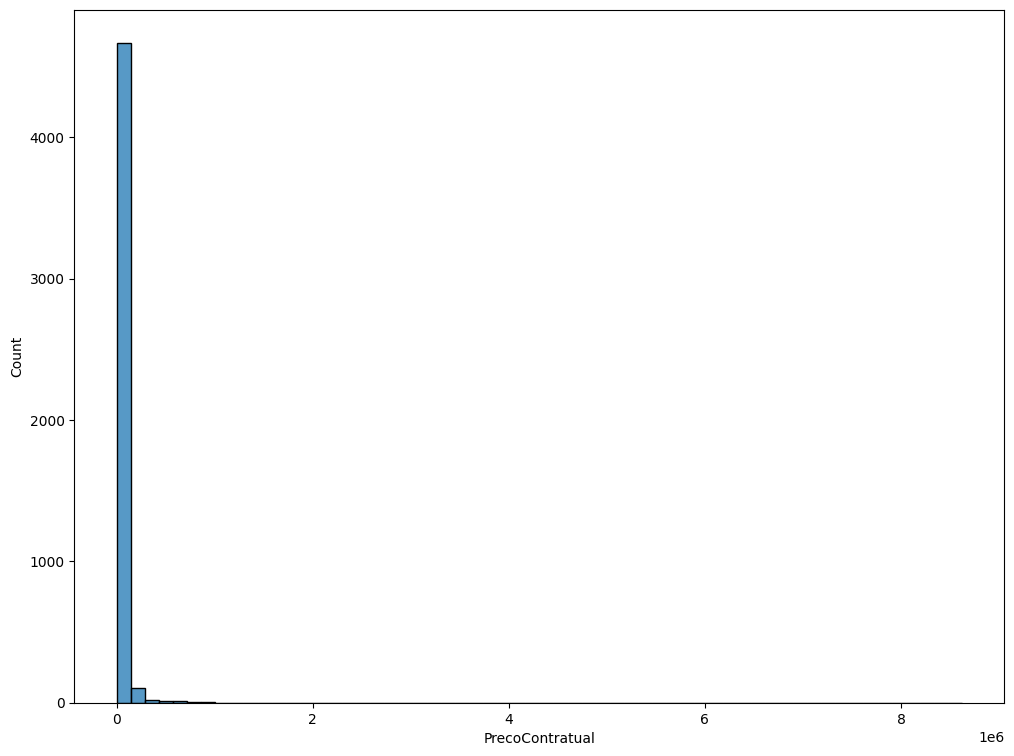

In [37]:
plt.figure(figsize=(12,9))
sns.histplot(ajustesdir.PrecoContratual, bins = 60)

<Axes: >

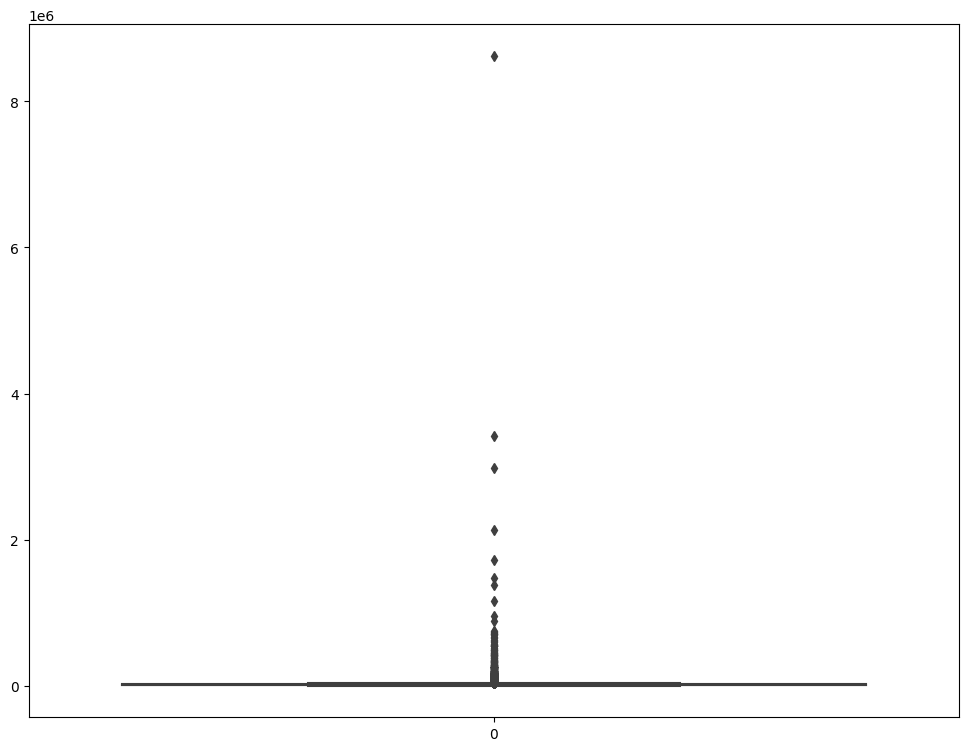

In [38]:
plt.figure(figsize=(12,9))
sns.boxplot(ajustesdir.PrecoContratual)


In [39]:
# Conjunto de fundamentações para ajustes diretos por ordem decrescente de ocorrência
(ajustesdir).groupby(21).size().sort_values(ascending = False)

21
Artigo 20.º, n.º 1, alínea d) do Código dos Contratos Públicos                                                     2468
Artigo 24.º, n.º 1, alínea e), subalínea iii) do Código dos Contratos Públicos                                     1016
Artigo 24.º, n.º 1, alínea e), subalínea ii) do Código dos Contratos Públicos                                       920
Artigo 20.º, n.º 1, alínea d) do Código dos Contratos Públicos e artigo 4.º, nº 1 do DLR nº 34/2008/M, de 14.08      95
Artigo 24.º, n.º 1, alínea c) do Código dos Contratos Públicos                                                       82
Artigo 20.º, alínea a) do Decreto Legislativo Regional n.º 27/2015/A, de 29.12                                       74
Artigo 21.º, n.º 1, alínea c) do Código dos Contratos Públicos                                                       32
Artigo 24.º, n.º 1, alínea e), subalínea i) do Código dos Contratos Públicos                                         27
Artigo 26.º, n.º 1, alínea a) do Códi

In [40]:
#HTML(ajustesdir.to_html(index = False))

In [41]:
# Valor máximo de um ajuste direto é mais de 3.000.000,00€

# Índice do array do valor mais alto 
print(np.where(ajustesdir.PrecoContratual > 3000000)[0])

# ID do contrato correspondente
# ajdir[30]

HTML((contrato(ajdir[30])).to_html(index=True))

[  26 2006]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,10042299,None,None,None,None,None,None,None,None,None,None,None,None,None,Ajuste Direto Regime Geral,Serviços de desenvolvimento e assistência técnica ao Monicap,2023-05-31,2023-05-26,74277.00,137,"Direção-Geral de Recursos Naturais, Segurança e Serviços Marítimos (600084973)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=339843)","Artigo 24.º, n.º 1, alínea e), subalínea iii) do Código dos Contratos Públicos","Xsealence - Sea Tecnoogies, S.A. (510808026)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=484152)",None,None,None,https://www.base.gov.pt/Base4/pt/resultados/?type=doc_documentos&id=2067510&ext=.pdf,false,72611000-6,False,None,None,False,False,None,False,None,False,Aquisição de serviços,Serviços de assistência técnica informática,Principal,74277.0,Aquisição de serviços de desenvolvimento e assistência técnica ao Monicap,ausência de recursos próprios,None,"Portugal, Lisboa, Oeiras",Não aplicável.,Não aplicável.,None,False,False,None,None,True,None,True,None,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1700375963


In [46]:
# ID's dos contratos com fla
rflag = redflag2(ajustesdir, ajdir)

In [47]:
# Ajustes Diretos com preço contratual superior a 20.000€
h(contratos(redflag2(ajustesdir, ajdir)).head(2))

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
10008447,None,None,None,None,None,None,None,None,None,None,None,None,None,Ajuste Direto Regime Geral,2023000661 - SISTEMA VEEAM BACKUP REPLICATION,2023-05-24,2023-05-16,18453.00,365,Estado-Maior-General das Forças Armadas (EMGFA) (600010180)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=1367),"Artigo 20.º, n.º 1, alínea d) do Código dos Contratos Públicos",Topick World Lda (507791010)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=104964),None,None,https://www.acingov.pt/acingovprod/2/zonaPublica/zona_publica_c/donwloadProcedurePiece/NjI3MjE3,https://www.base.gov.pt/Base4/pt/resultados/?type=doc_documentos&id=2001580&ext=.pdf,false,72260000-5,False,None,None,False,False,None,False,None,False,Aquisição de serviços,Serviços relacionados com software,Principal,18453.0,2023000661 - SISTEMA VEEAM BACKUP REPLICATION,ausência de recursos próprios,None,"Portugal, Lisboa, Lisboa",Não aplicável.,Não aplicável.,None,False,False,None,None,False,None,True,None,"Código dos Contratos Públicos (DL111-B/2017) e Lei n.º 30/2021, de 21.05",None,None,1700352375
10008728,None,None,None,None,None,None,None,None,None,None,None,None,None,Ajuste Direto Regime Geral,"AQUISIÇÃO DE SERVIÇO ESPECIALIZADO PARA ASSEGURAR A ESTABILIDADE E SEGURANÇA DO SITE MUNICIPAL (MANUTENÇÃO, EVOLUÇÃO E CONCEÇÃO DE PEQUENOS MICROSITES)",2023-05-24,2023-05-24,9900.00,365,Município de Felgueiras (501091823)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=1445),"Artigo 20.º, n.º 1, alínea d) do Código dos Contratos Públicos","Ricardo Jorge da Cunha Alves, Unipessoal, Lda. (509888550)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=249643)",None,None,https://www.acingov.pt/acingovprod/2/zonaPublica/zona_publica_c/donwloadProcedurePiece/NjMyNDAy,None,false,72413000-8,False,None,None,False,False,None,False,None,False,Aquisição de serviços,Serviços de concepção de sítios da World Wide Web (WWW),Principal,9900.0,"AQUISIÇÃO DE SERVIÇO ESPECIALIZADO PARA ASSEGURAR A ESTABILIDADE E SEGURANÇA DO SITE MUNICIPAL (MANUTENÇÃO, EVOLUÇÃO E CONCEÇÃO DE PEQUENOS MICROSITES)",ausência de recursos próprios,None,"Portugal, Porto, Felgueiras",Não aplicável.,Não aplicável.,None,False,False,None,None,False,"Artigo 95.º, n.º 1, a), contrato de locação ou de aquisição de bens móveis ou de aquisição de serviços cujo preço contratual não excede 10.000,00 € e para Região Autónoma da Madeira um coeficiente de 1,35 €",True,None,"Código dos Contratos Públicos (DL111-B/2017) e Lei n.º 30/2021, de 21.05",None,None,1700352283


In [48]:
print('Nr de Ajustes Diretos :', len(ajustesdir))
print('Nr de Ajustes Diretos Suspeitos :', len(contratos(redflag2(ajustesdir, ajdir))))
print('% = ', round(len(contratos(redflag2(ajustesdir, ajdir)))/len(ajustesdir), 3)*100 )

Nr de Ajustes Diretos : 4830
Nr de Ajustes Diretos Suspeitos : 1201
% =  24.9


In [49]:
# As colunas da dataframe de entidade adjudicante e entidade adjudicataria vão ser decompostas em 3 novas colunas: Entidade-NIF-URL
ajustesdir = ajustesdir.rename(columns={20: 'Adjudicante', 21:'Fundamentação', 22:'Adjudicatária'})


# Separação dos elementos de cada coluna em Entidade-NIF-URL
# O objetivo é contar o número de ocorrências de cada NIF
pattern = r'^(?P<EntidadeAdjudicante>.*?)\s?\((?P<NIF1>[\w\.-]+)\)\((?P<URL1>.*?)\)$'
pattern1 = r'^(?P<EntidadeAdjudicataria>.*?)\s?\((?P<NIF2>[\w\.-]+)\)\((?P<URL2>.*?)\)$'


Df_extracted = ajustesdir['Adjudicante'].str.extract(pattern)
Df_extracted1 = ajustesdir['Adjudicatária'].str.extract(pattern1)


# Correr linhas abaixo só uma vez
# Caso contrário está sempre a adicionar à dataframe as mesas colunas
ajustesdir = pd.concat([ajustesdir, Df_extracted], axis=1)
ajustesdir = pd.concat([ajustesdir, Df_extracted1], axis=1)


h(ajustesdir.head(2))

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,PrecoContratual,19,Adjudicante,Fundamentação,Adjudicatária,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,TipoProcedimento,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,EntidadeAdjudicante,NIF1,URL1,EntidadeAdjudicataria,NIF2,URL2
10323628,None,None,None,None,None,None,None,None,None,None,None,None,None,Ajuste Direto Regime Geral,Serviço Via Verde Estacionar,2023-11-02,2023-10-20,19990.0,731,"Loures Parque - Empresa Municipal de Estacionamento, E. M., Unipessoal, L.da (505072947)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=4381)","Artigo 20.º, n.º 1, alínea d) do Código dos Contratos Públicos","Via Verde Portugal ? Gestão de Sistemas Eletrónicos de Cobrança, S.A. (504656767)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=31977)",None,None,None,https://www.base.gov.pt/Base4/pt/resultados/?type=doc_documentos&id=2071227&ext=.pdf,false,72000000-5,False,None,None,False,False,None,False,None,False,Aquisição de serviços,"Serviços de TI: consultoria, desenvolvimento de software, Internet e apoio",Principal,19990.0,Ajuste Direto N.º 08/23 - Serviço Via Verde Estacionar,Não aplicável,None,"Portugal, Lisboa, Loures",Não aplicável.,Não aplicável.,None,False,False,None,None,False,None,True,N/A,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699382401,"Loures Parque - Empresa Municipal de Estacionamento, E. M., Unipessoal, L.da",505072947,https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=4381,"Via Verde Portugal ? Gestão de Sistemas Eletrónicos de Cobrança, S.A.",504656767,https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=31977
10323670,None,None,None,None,None,None,None,None,None,None,None,None,None,Ajuste Direto Regime Geral,Prestação de Serviços de Assistência Técnica Informática,2023-11-02,2023-10-04,10000.0,366,Freguesia de São Gonçalo de Lagos (510837433)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=934188),"Artigo 20.º, n.º 1, alínea d) do Código dos Contratos Públicos",Algardata Sistemas Informáticos SA (502420227)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=320),None,None,None,None,false,72611000-6,False,None,None,False,False,None,False,None,False,Aquisição de serviços,Serviços de assistência técnica informática,Principal,10000.0,Prestação de Serviços de Assistência Técnica Informática,Não aplicável,None,"Portugal, Faro, Lagos",Não aplicável.,Não aplicável.,None,False,False,None,None,False,"Artigo 95.º, n.º 1, a), contrato de locação ou de aquisição de bens móveis ou de aquisição de serviços cujo preço contratual não excede 10.000,00 € e para Região Autónoma da Madeira um coeficiente de 1,35 €",True,None,"Código dos Contratos Públicos (DL111-B/2017) e Lei n.º 30/2021, de 21.05",None,None,1699382337,Freguesia de São Gonçalo de Lagos,510837433,https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=934188,Algardata Sistemas Informáticos SA,502420227,https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=320


In [50]:
counts = ajustesdir.groupby('NIF1').size().reset_index(name='Count')
counts1 = ajustesdir.groupby('NIF2').size().reset_index(name='Count')

# Entidades Adjudicantes com mais ajustes diretos celebrados
h(counts.sort_values(by = ['Count'], ascending=False))

NIF1,Count
502017368,95
501413197,54
500225680,47
506361616,45
501559094,41
509822940,40
508142156,38
506361470,36
501306099,35
500051070,33


In [52]:
# Entidades Adjudicatárias com mais ajustes diretos celebrados
h(counts1.sort_values(by = ['Count'], ascending=False))

NIF2,Count
-,265
501378669,138
502479418,84
504990926,80
504615947,77
505331187,72
511135610,53
505141019,52
504551221,51
501941231,47


In [53]:
C1 = counts.sort_values(by = ['Count'], ascending=False)
C2 = counts1.sort_values(by = ['Count'], ascending=False)

In [54]:
def e_adjudicante(df,nif):
    """
    Função que retorna id's dos contratos a partir do NIF da entidade adjudicante

    Parâmetros:
        df : dataframe. Neste caso terá de ser a dataframe chamada ajustesdir porque já sofreu alterações, tais como, a inserção de colunas para os NIF's e etc
        nif : NIF da entidade

    return:
        ids dos ajustes diretos celebrados para a entidade adjudicante com o NIF em questão
    """

    index = (np.where(df.NIF1 == nif)[0])
    ids = np.array(df.iloc[index,0])

    ids = ids.reshape((len(ids),1))
    ids = tuple(map(tuple,ids))
    
    return ids



def e_adjudicataria(df,nif):
    """
    Função que retorna id's dos contratos a partir do NIF da entidade adjudicatária

    Parâmetros:
        df : dataframe. Neste caso terá de ser a dataframe chamada ajustesdir porque já sofreu alterações, tais como, a inserção de colunas para os NIF's e etc
        nif : NIF da entidade

    return:
        ids dos ajustes diretos celebrados para a entidade adjudicatária com o NIF em questão
    """

    index = (np.where(df.NIF2 == nif)[0])
    ids = np.array(df.iloc[index,0])

    ids = ids.reshape((len(ids),1))
    ids = tuple(map(tuple,ids))
    
    return ids

In [55]:
def entidadeI(df,nif):
    """
    Função que retorna nome da entidade adjudicante a partir do NIF
    
    Parâmetros:
        df : dataframe. Neste caso terá de ser a dataframe chamada ajustesdir porque já sofreu alterações, tais como, a inserção de colunas para os NIF's e etc
        nif : NIF da entidade

    return:
        nome da entidade
    """

    index = (np.where(df.NIF1 == nif)[0])
    i = index[0]
    
    return df.EntidadeAdjudicante[i]



def entidadeII(df,nif):
    """
    Função que retorna nome da entidade adjudicatária a partir do NIF
    
    Parâmetros:
        df : dataframe. Neste caso terá de ser a dataframe chamada ajustesdir porque já sofreu alterações, tais como, a inserção de colunas para os NIF's e etc
        nif : NIF da entidade

    return:
        nome da entidade
    """

    index = (np.where(df.NIF2 == nif)[0])
    i = index[0]
    
    return df.EntidadeAdjudicataria[i]

In [56]:
# PARA ENTIDADES ADJUDICANTES

# Este array vai servir para guardar o número de ajustes diretos suspeitos para cada NIF
# O NIF com mais ajustes diretos está na posição 0 do array, o segundo na posição 1 e assim sucessivamente
# Neste caso, o número de ajustes diretos suspeitos referentes à empresa com mais ajustes diretos realizados está na posição 0
ents = np.zeros(len(C1.NIF1))

# Lista com os nomes das entidades adjudicantes
name = list()

# Lista que vai conter o número de ajustes diretos realizados para cada entidade
cel  = np.zeros(len(C1.NIF1))


for i,j in enumerate(C1.NIF1):

    # Nome da entidade adjudicante
    name.append(entidadeI(ajustesdir, j))

    # ID's dos ajustes diretos celebrados
    x = e_adjudicante(ajustesdir,j)

    # Número de ajustes diretos celebrados
    cel[i] = len(x)
    
    for k in x:
        if k in rflag:
            ents[i] += 1        

# Percentagem de contratos suspeitos
perc = np.round(ents/cel*100,2)

newdf = pd.DataFrame({'EntidadeAdjudicante': name, 'NIF':C1.NIF1, 'Celebrados': cel, 'Suspeitos': ents, '%':perc})
h(newdf)

EntidadeAdjudicante,NIF,Celebrados,Suspeitos,%
Autoridade Nacional de Comunicações,502017368,95.0,29.0,30.53
Universidade do Porto,501413197,54.0,7.0,12.96
"Rádio e Televisão de Portugal, S. A.",500225680,47.0,18.0,38.30
"Instituto Português de Oncologia de Lisboa Francisco Gentil, E. P. E.",506361616,45.0,9.0,20.00
Universidade Nova de Lisboa,501559094,41.0,18.0,43.90
"Centro Hospitalar Tondela-Viseu, E. P. E.",509822940,40.0,11.0,27.50
"Centro Hospitalar Vila Nova de Gaia - Espinho, E. P. E.",508142156,38.0,7.0,18.42
"Hospital Garcia de Orta, E. P. E.",506361470,36.0,7.0,19.44
Município do Porto,501306099,35.0,17.0,48.57
Município de Lisboa,500051070,33.0,3.0,9.09


In [57]:
# PARA ENTIDADES ADJUDICATÁRIAS

# Este array vai servir para guardar o número de ajustes diretos suspeitos para cada NIF
# O NIF com mais ajustes diretos está na posição 0 do array, o segundo na posição 1 e assim sucessivamente
# Neste caso, o número de ajustes diretos suspeitos referentes à empresa com mais ajustes diretos realizados está na posição 0
ents1 = np.zeros(len(C2.NIF2))

# Lista com os nomes das entidades adjudicatárias
name1 = list()

# Lista que vai conter o número de ajustes diretos realizados para cada entidade
cel1  = np.zeros(len(C2.NIF2))


for i,j in enumerate(C2.NIF2):
    
    # Nome da entidade adjudicante
    name1.append(entidadeII(ajustesdir, j))

    # ID's dos ajustes diretos celebrados
    x1 = e_adjudicataria(ajustesdir,j)

    # Número de ajustes diretos celebrados
    cel1[i] = len(x1)
    
    for k in x1:
        if k in rflag:
            ents1[i] += 1        

# Percentagem de contratos suspeitos
perc1 = np.round(ents1/cel1*100,2)

newdf1 = pd.DataFrame({'EntidadeAdjudicatárias': name1, 'NIF':C2.NIF2, 'Celebrados': cel1, 'Suspeitos': ents1, '%':perc1})
h(newdf1)

EntidadeAdjudicatárias,NIF,Celebrados,Suspeitos,%
Vítor José Cardoso Parada,-,265.0,69.0,26.04
AIRC - Associação de Informatica da Região Centro,501378669,138.0,28.0,20.29
"GLINTT - HEALTHCARE SOLUTIONS, SA.",502479418,84.0,24.0,28.57
Medidata,504990926,80.0,19.0,23.75
"MEO - Serviços de Comunicações e Multimédia, S. A.",504615947,77.0,13.0,16.88
WireMaze - Sistemas de Informação S.A.,505331187,72.0,15.0,20.83
"ACIN-ICLOUD Solutions, Lda.",511135610,53.0,14.0,26.42
"Vortal - Comércio Eletrónico Consultadoria e Multimédia, SA",505141019,52.0,12.0,23.08
"Link Consulting - Tecnologias de Informação, S.A.",504551221,51.0,18.0,35.29
"Esri Portugal - Sistemas e Informação Geográfica, S.A.",501941231,47.0,14.0,29.79


In [58]:
n1 = np.array(ajustesdir.NIF1)
n2 = np.array(ajustesdir.NIF2)

print('Número de Ajustes Diretos :', len(n1))
print('Número de NIFs de entidades adjudicantes :', len(C1)) 
print('Número de NIFs de entidades adjudicatárias :', len(C2)) 

Número de Ajustes Diretos : 4830
Número de NIFs de entidades adjudicantes : 1143
Número de NIFs de entidades adjudicatárias : 1478


# Plots

In [59]:
cur = conn.cursor()
cur.execute('''
            SELECT column_name
            FROM information_schema.columns
            WHERE table_name = 'contratos';''')

h(pd.DataFrame(cur.fetchall()))

0
id
n_anuncio
anuncio_preco_base
anuncio_proposalDeadline
anuncio_cnccs
anuncio_contractingProcedureAliasID
anuncio_contractingProcedureId
anuncio_drPublicationDate
anuncio_dreNumber
anuncio_dreSeries


In [61]:
def contracts_year(Y):

    cur = conn.cursor()
    cur.execute('''
                SELECT COUNT(*) 
                FROM "contratos"
                WHERE EXTRACT(YEAR FROM data_publicacao::timestamp) = %s;''', (Y,))
    
    return cur.fetchone()[0]

In [62]:
def pcontratual_ano(year):
    cur = conn.cursor()
    cur.execute('''
                SELECT SUM(CAST(preco_contratual AS FLOAT))
                FROM "contratos"
                WHERE EXTRACT(YEAR FROM data_publicacao::timestamp) = %s;''', (year,))
    
    return cur.fetchone()[0]

In [65]:
C2023 = contracts_year(2023)
P2023 = pcontratual_ano(2023)

C2022 = contracts_year(2022)
P2022 = pcontratual_ano(2022)

In [66]:
print(C2023,P2023,C2022,P2022)

172530 13665481914.419998 28951 1926885901.6900008


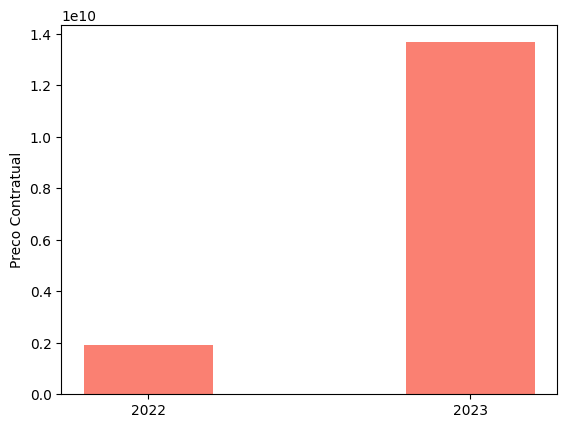

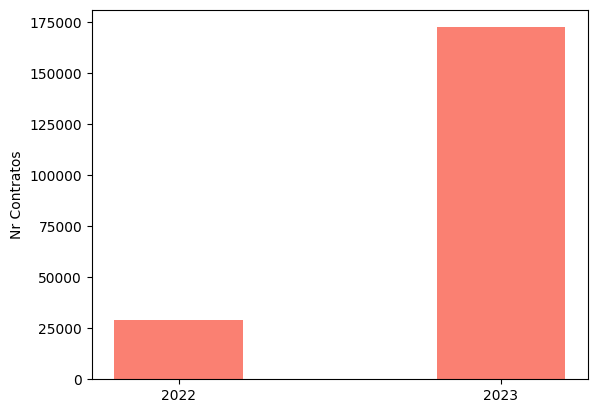

In [68]:
anos = np.array([2022, 2023])
prices = np.array([P2022,P2023])
contracts = np.array([C2022,C2023])

plt.bar(anos, prices, tick_label = [2022,2023], width = .4, align = 'center', color = 'salmon')
plt.ylabel('Preco Contratual')
plt.show()

plt.bar(anos, contracts, tick_label = [2022,2023], width = .4, align = 'center', color = 'salmon')
plt.ylabel('Nr Contratos')
plt.show()